In [137]:
#@title Set parameters and `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random
import glob

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

#@markdown - Time (Unit: Hrs)
T_DOUBLING = 48 # @param {"type":"slider","min":1,"max":100,"step":1}
T_TOTAL = 168 # @param {"type":"slider","min":1,"max":500,"step":1}

#@markdown - Exponential : Number of cells
E_START_CELL_K = 5900 # @param {"type":"slider","min":100,"max":10000,"step":50}
E_END_CELL_K = 16000 # @param {"type":"slider","min":100,"max":50000,"step":50}
E_LOGISTIC = 0.6 # @param {type:"slider", min:0.0, max:1, step:0.05}

#@markdown - Linear : Number of cells
L_START_CELL_K = 9200 # @param {"type":"slider","min":100,"max":50000,"step":50}
L_END_CELL_K = 10800 # @param {"type":"slider","min":100,"max":50000,"step":50}

# Run

In [138]:
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
from scipy.optimize import brentq



import numpy as np
from scipy.optimize import brentq

def logistic_with_doubling_and_endpoint(
    N0,
    NT,
    T,
    doubling_time,
    t
):
    """
    Logistic growth that:
    - starts at N0
    - has early doubling time = doubling_time
    - ends at NT at time T
    """

    # Growth rate from doubling time (early exponential)
    r = np.log(2) / doubling_time

    # Logistic endpoint equation to solve for K
    def endpoint_error(K):
        A = (K - N0) / N0
        NT_pred = K / (1 + A * np.exp(-r * T))
        return NT_pred - NT

    # K must be > NT
    K_min = NT * 1.000001
    K_max = NT * 1e6  # large upper bound

    # Solve for carrying capacity
    K = brentq(endpoint_error, K_min, K_max)

    # Construct curve
    A = (K - N0) / N0
    N = K / (1 + A * np.exp(-r * t))

    return N, K



def logistic_constrained_safe(N0, NT, T, doubling_time, noise, t):
    r = np.log(2) / doubling_time

    def logistic_N(K):
        A = (K - N0) / N0
        return K / (1 + A * np.exp(-r * T))

    def endpoint_error(K):
        return logistic_N(K) - NT

    # Reasonable K bounds
    K_min = max(NT * 1.000001, N0 * 1.000001)
    K_max = max(K_min * 10, NT * 100)

    f_min = endpoint_error(K_min)
    f_max = endpoint_error(K_max)

    # ------------------------
    # Case 1: Valid logistic
    # ------------------------
    if f_min * f_max < 0:
        from scipy.optimize import brentq
        K = brentq(endpoint_error, K_min, K_max)

        A = (K - N0) / N0
        return K / (1 + A * np.exp(-r * t)), "logistic"

    # ------------------------
    # Case 2: Logistic impossible → fallback
    # ------------------------
    # Blend exponential & linear based on noise
    k_eff = np.log(NT / N0) / T
    N_exp = N0 * np.exp(k_eff * t)
    N_lin = N0 + (NT - N0) * (t / T)

    N_blend = (1 - noise) * N_exp + noise * N_lin
    return N_blend, "fallback"


def visualize_cell_growth(
    EN0,
    ENT,
    noise,
    LN0,
    LNT,
    doubling_time,
    T,
    n_points=2000
):
    """
    Visualize exponential, logistic (noise-controlled), and linear growth models.

    N0            : initial cell count
    NT            : final cell count
    T             : total time
    doubling_time : expected doubling time
    noise         : [0, 1), 0=exponential-like, ->1 logistic saturation
    """

    t = np.linspace(0, T, n_points)

    # --------------------
    # Exponential (endpoint constrained)
    # --------------------
    k = np.log(ENT / EN0) / T
    N_exp = EN0 * np.exp(k * t)

    # --------------------
    # Logistic with noise
    # --------------------
    N_log, K = logistic_with_doubling_and_endpoint(
        EN0, ENT, T, doubling_time, t
    )
    #N_log, mode = logistic_constrained_safe(
    #    EN0, ENT, T, doubling_time, noise, t
    #)

    # --------------------
    # Linear
    # --------------------
    N_lin = LN0 + (LNT - LN0) * (t / T)

    # --------------------
    # AUCs
    # --------------------
    auc_exp = np.trapz(N_exp, t)
    auc_log = np.trapz(N_log, t)
    auc_lin = np.trapz(N_lin, t)

    # --------------------
    # Plot
    # --------------------
    plt.figure(figsize=(8, 5))

    plt.plot(t, N_exp, label=f"Naive fit: Exponential (AUC={auc_exp:.2e})")
    plt.plot(t, N_log, label=f"Logistic, noise={noise} (AUC={auc_log:.2e})")
    plt.plot(t, N_lin, label=f"Linear (AUC={auc_lin:.2e})")

    #plt.scatter([0, T], [EN0, ENT], zorder=5)

    plt.xlabel("Time (Hrs)")
    plt.ylabel("Cell count")
    plt.title("Cell growth models")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot

/tmp/ipython-input-719149109.py:136: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_exp = np.trapz(N_exp, t)
/tmp/ipython-input-719149109.py:137: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_log = np.trapz(N_log, t)
/tmp/ipython-input-719149109.py:138: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_lin = np.trapz(N_lin, t)


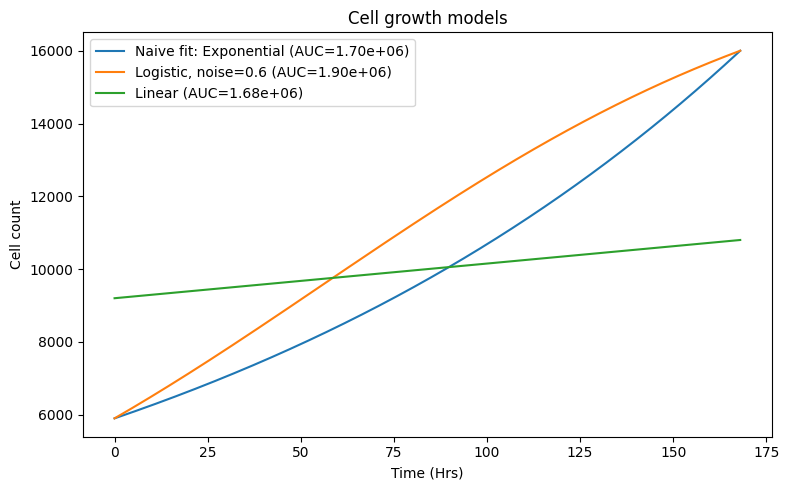

In [139]:
visualize_cell_growth(
    EN0=E_START_CELL_K,
    ENT=E_END_CELL_K,
    noise=E_LOGISTIC,
    LN0=L_START_CELL_K,
    LNT=L_END_CELL_K,
    doubling_time=T_DOUBLING,
    T=T_TOTAL,
)